# Exercise 6

This week we will practice how to work with OpenStreetMap data and conduct network analysis in Python.

## Problem 1 (8 points)

There are two csv-files in the [/data](./data) folder:

- `origins.csv`
- `destinations.csv`

The files contain coordinates of the origin and destination points in certain area of the world as latitude and longitude coordinates (decimal degrees). 

**1: Your task is to find out where the points are located based on the coordinates found in the files** (which city/country?) Use your GIS skills to find out the solution in two different ways.

A. detect the location using **visualization techniques**; plot the points on top of a background map and see where they are located! 

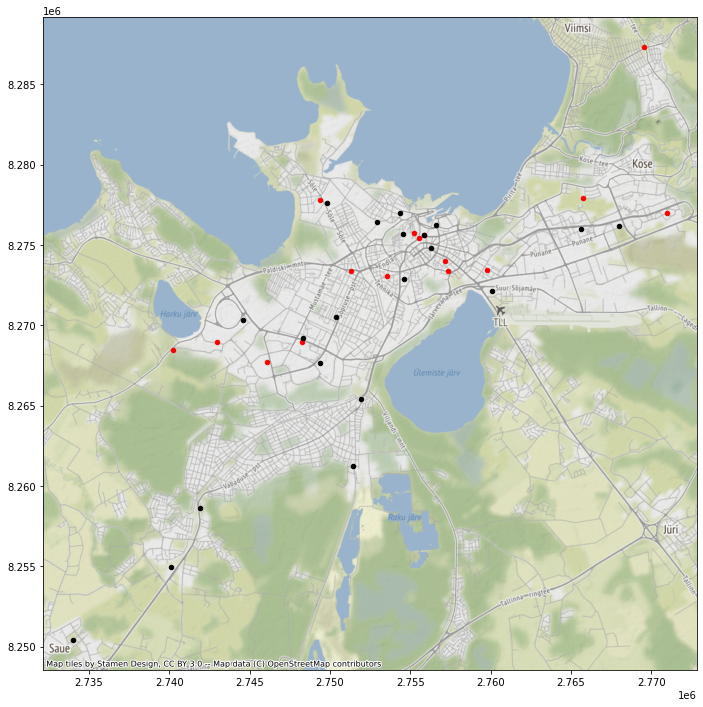

In [1]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import contextily as ctx

#1. define relative paths 
orig_fpath = r'data/origins.csv'
dest_fpath = r'data/destinations.csv'

#2. read text files
data_orig = pd.read_csv(orig_fpath)
data_dest = pd.read_csv(dest_fpath)

#3. create empty geometry col
data_orig['geometry'] = None
data_dest['geometry'] = None

#4. func to create Point objects
def create_point(row):
    """read x (longitute), then y (latitude)"""
    pnt = Point(row[0], row[1])
    return pnt

#5. create point objects
data_orig['geometry'] = data_orig.apply(create_point, axis=1)
data_dest['geometry'] = data_dest.apply(create_point, axis=1)

#6. create geo df and place data origin/destination; default crs is 4326
geo_orig = gpd.GeoDataFrame(data_orig, geometry='geometry', crs=CRS.from_epsg(4326).to_wkt())
geo_dest = gpd.GeoDataFrame(data_dest, geometry='geometry', crs=CRS.from_epsg(4326).to_wkt())

#7. project data from default to ESPG:3857. OpenStreetMap requires data in this CRS
geo_orig_proj = geo_orig.to_crs(CRS.from_epsg(3857))
geo_dest_proj = geo_dest.to_crs(CRS.from_epsg(3857))

#8. add a basemap using contextily
fig, ax = plt.subplots(figsize=(12,12))

geo_orig_proj.plot(ax=ax, facecolor='red', markersize=20)
geo_dest_proj.plot(ax=ax, facecolor='black', markersize=20)

ctx.add_basemap(ax)

# points are located in Tallin, Estonia

B. Detect the location using **geocoding techniques**; reverse geocode at least one of the locations (see [hints from geopy documentation ](https://geopy.readthedocs.io/en/stable/index.html?highlight=reverse#module-geopy.geocoders)). As output, you should print out information about the location (can be a full address, or just the name of the city):

In [66]:
# import required libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
from geopandas.tools import geocode

# allow to display all data when using pd.head()
pd.set_option('display.max_colwidth', None)

#1. define relative path 
orig_fpath = r'data/origins.csv'

#2. read text files and save to pd
data_orig_v2 = pd.read_csv(orig_fpath)

#3. Geocode addresses using Nominatim.
geolocator = Nominatim(user_agent="hello_world")

#4. find address using (lat, lon)
def geocode_lat_lon(row):
    """read (y, x) and returns address"""
    lat_lon = "%s, %s" % (row[1], row[0])
    location = geolocator.reverse(lat_lon)
    return location

# data is located in Tallin, Estonia
data_orig_v2 = data_orig_v2.apply(geocode_lat_lon, axis=1)

# data is located in Tallin, Estonia
data_orig_v2.head(1)


0    (Astangu mini-Rimi, 4, Kotermaa, Astangu, Haabersti linnaosa, Tallinn, Harju maakond, 13524, Eesti, (59.405099500000006, 24.615690363597032))
dtype: object

**2: Retrieve OpenStreetMap data (only streets that can be driven with car) from the area where the points are located.**

- Specify a Polygon that covers the **extent where all the points are located** 
- hint: combine the origin and destination points into one layer, and define a convex hull for the combined points
- store the polygon in a variable called `extent`

In [3]:
# import modules
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS

#1. copy origin and destination geo df (CRS:4326)
orig_copy = geo_orig.copy()
dest_copy = geo_dest.copy()

#2. combine data into one layer 
orig_dest = orig_copy.append(dest_copy)

#3. combine all geometries and then create a polygon from them
convex_hull = orig_dest.unary_union.convex_hull

# 4. create a buffer of 0.05 degree to allow a better routing 
extent = convex_hull.buffer(distance=0.05)

In [4]:
# NON-EDITABLE TEST CELL
# The extent should be a shapely Polygon
print(extent)

POLYGON ((24.57489872682261 59.27473420043327, 24.57011740337949 59.27347606733402, 24.56523520068804 59.27269629195442, 24.56029985488103 59.27240249861146, 24.55535962170239 59.27259755989338, 24.55046280468269 59.27327956857268, 24.5456572828475 59.27444185625419, 24.54099004257631 59.27607305857583, 24.53650671818943 59.27815722632459, 24.53225114575465 59.2806739813813, 24.52826493447661 59.28359871596925, 24.52458705985939 59.28690283325879, 24.52125348262034 59.29055402697515, 24.5182967970813 59.29451659727564, 24.51574591247492 59.29875179980775, 24.51362577028234 59.30321822453524, 24.51195710036579 59.30787220062808, 24.51075621828073 59.31266822345755, 24.51003486574913 59.31755939952147, 24.50980009585388 59.32249790494917, 24.51005420407668 59.32743545310328, 24.51079470585376 59.33232376670627, 24.51201436086894 59.33711504987543, 24.51370124384639 59.34176245545096, 24.51583886115099 59.34622054304792, 24.51840631205615 59.35044572335326, 24.57450631205615 59.4332457233

In [5]:
# NON-EDITABLE TEST CELL
# The extent should be a shapely Polygon
print(type(extent))

<class 'shapely.geometry.polygon.Polygon'>


- Use the polygon to fetch the network data with `.graph_from_polygon()` function 
- see [osmnx docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_polygon) for more details
- store the street network a variable called `graph`

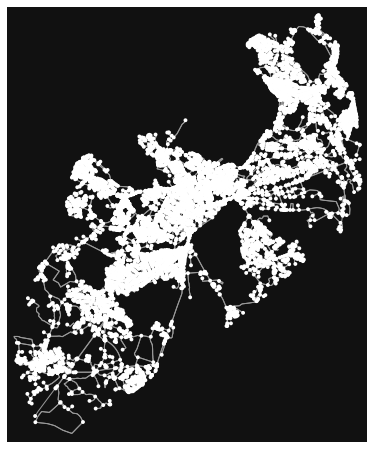

In [6]:
# get auto network from OSM using extent of points
graph = ox.graph_from_polygon(polygon=extent, network_type='drive')

fig, ax = ox.plot_graph(graph)

In [7]:
# NON-EDITABLE TEST CELL
# The graph should be a networkx MultiDiGraph
print(type(graph))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [8]:
# NON-EDITABLE TEST CELL
# Check the graph size. The example solution graph size is 74726 (don't panic if yours is not exactly the same, you can still proceed!)
print(graph.size())

22630


**3: Reproject the data into UTM projection, and plot:**
  - the street network (with `gray` color and line width of `0.5` and alpha set to `0.7`)
  - the origin points (with `red` color)
  - destination points (with `blue` color)
  
In the end you should have a map that looks something like following:

![](img/route_network_with_OD_points.png)

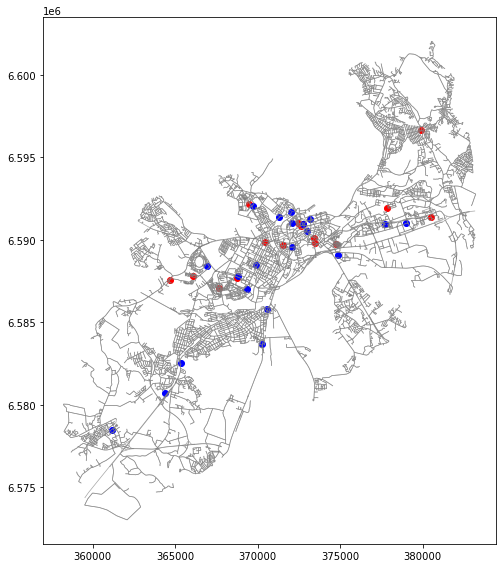

In [9]:
#1. project graph to a local crs
graph_proj = ox.project_graph(graph)

#2. get nodes/edges from the graph
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

#3. project data from default to ESPG:3857. OpenStreetMap requires data in this CRS
orig_proj_pnts = geo_orig_proj.to_crs(CRS(edges_proj.crs))
dest_proj_pnts = geo_dest_proj.to_crs(CRS(edges_proj.crs))

#4. plot data
fig, ax = plt.subplots(figsize=(12,8))

edges_proj.plot(ax=ax, color='gray', linewidth=0.7, alpha=0.7)
orig_proj_pnts.plot(ax=ax, color='red')
dest_proj_pnts.plot(ax=ax, color='blue')
plt.tight_layout();

### Done!

That's it! Now you can continue with problem 2. 

## Problem 2 (12 points)

In this problem we practice conducting shortest path routing.

### Steps

**1: Calculate the shortest paths between all origin points (16) and destination points (20) using the `length` of the road segments as the impedance measure (in total 320 routes).** 

- To be able to find the shortest paths, you should find the nearest nodes from the graph for both origin and destination points. 
- Notice: if the closest node is the same for both origin and destination point, you should skip the shortest path calculation. - After the routing, you should add the shortest path routes as LineString geometries into a GeoDataFrame called `routes`. 
- You should use the projected graph as the network for the analyses
- remember to use informative variable names, and to comment your code!

In [55]:
# display 50 characters when using pd.head() because we don't need to see full address line
pd.set_option('display.max_colwidth', 50)

# create empty geo df
routes = gpd.GeoDataFrame(geometry='geometry', crs=nodes_proj.crs, columns=['geometry'])

#1. define functions
def change_xy_to_yx(row):
    """Function to change from (x,y) format to (y,x) for OSMNX"""
    coord_pair = (row.geometry.y, row.geometry.x)
    return coord_pair

def find_nearest_node(row, graph_file=graph_proj, method='euclidean'):
    """Function to find the nearest node"""
    nearest_node = ox.get_nearest_node(graph_file, row['lat_lon'], method)
    return nearest_node

#2. create a new col to store results
orig_proj_pnts['lat_lon'] = None
dest_proj_pnts['lat_lon'] = None

orig_proj_pnts['node_id'] = None
dest_proj_pnts['node_id'] = None

#3. swap (x,y) for O/D
orig_proj_pnts['lat_lon'] = orig_proj_pnts.apply(change_xy_to_yx, axis=1)
dest_proj_pnts['lat_lon'] = dest_proj_pnts.apply(change_xy_to_yx, axis=1)

#4. find the nearest node for O/D
orig_proj_pnts['node_id'] = orig_proj_pnts.apply(find_nearest_node,
                                                 graph_file=graph_proj,
                                                 method='euclidean', 
                                                 axis=1)

dest_proj_pnts['node_id'] = dest_proj_pnts.apply(find_nearest_node,
                                                 graph_file=graph_proj,
                                                 method='euclidean', 
                                                 axis=1)
#5. find routes for all O/D pairs

#5a get the number of recs for iterations number, which is 16 and 20
orig_iter = len(orig_proj_pnts)
dest_iter = len(dest_proj_pnts)

#5b initialize counter for storing results
rec_num = 0

# 5c find routes for all O-D combinations
for i in range(orig_iter):
    for j in range(dest_iter):
        
        # using .loc index to get node_id
        orig_node_id = orig_proj_pnts.loc[i, 'node_id']
        dest_node_id = dest_proj_pnts.loc[j, 'node_id']
        
        # assert that node id for O/D are not the same
        if orig_node_id != dest_node_id:
            # find shortest route (a list on travelled nodes); returns a list of point_ids
            route = nx.shortest_path(G=graph_proj, source=orig_node_id, target=dest_node_id, weight='length')
            
            # select node records for each shortest route; use .loc index
            route_nodes = nodes_proj.loc[route]
            
            # create a line object 
            route_line = LineString(list(route_nodes.geometry.values))
            
            # save data to route geo df
            routes.at[rec_num, 'geometry'] = route_line
            
            # add new index
            rec_num += 1
        
routes.head()

,geometry
0,"LINESTRING (364723.463 6587654.193, 364688.064..."
1,"LINESTRING (364723.463 6587654.193, 364688.064..."
2,"LINESTRING (364723.463 6587654.193, 364688.064..."
3,"LINESTRING (364723.463 6587654.193, 365376.539..."
4,"LINESTRING (364723.463 6587654.193, 364688.064..."


**2: Calculate the distance of the routes in meters into a new column called `route_dist`.**
 

In [71]:
route[0:5]

[10581174, 278373231, 60294640, 31288164, 10581179]

In [72]:
route_nodes.head(5)

,y,x,osmid,lon,lat,highway,geometry
10581174,6.591000e+06,372468.155674,10581174,24.751303,59.438172,NaN,POINT (372468.156 6590999.766)
278373231,6.590981e+06,372596.898483,278373231,24.753582,59.438044,NaN,POINT (372596.898 6590981.150)
60294640,6.590879e+06,372564.274362,60294640,24.753068,59.437122,NaN,POINT (372564.274 6590879.457)
31288164,6.590874e+06,372563.984169,31288164,24.753066,59.437076,NaN,POINT (372563.984 6590874.396)
10581179,6.590836e+06,372600.497317,10581179,24.753732,59.436739,NaN,POINT (372600.497 6590835.606)


In [75]:
print(list(route_nodes.geometry.values[0:5]))

[<shapely.geometry.point.Point object at 0x0000000010219508>, <shapely.geometry.point.Point object at 0x000000001298BAC8>, <shapely.geometry.point.Point object at 0x000000000FE77248>, <shapely.geometry.point.Point object at 0x0000000012BC5A08>, <shapely.geometry.point.Point object at 0x0000000010219588>]


In [56]:
routes['route_dist'] = routes.length

In [57]:
# NON-EDITABLE TEST CELL
print("Shortest distance:", round(routes['route_dist'].min()), "meters")

Shortest distance: 96 meters


In [58]:
# NON-EDITABLE TEST CELL
print("Longest distance:", round(routes['route_dist'].max()), "meters")

Longest distance: 29177 meters


**3: Plot all the routes on top of the street network.** 

In the end you should have something like following:
 
 ![](img/routings.png)

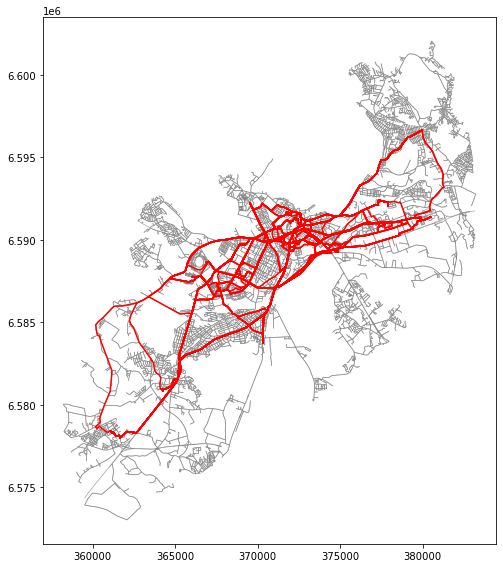

In [77]:
# plot data
fig, ax = plt.subplots(figsize=(12,8))

edges_proj.plot(ax=ax, color='gray', linewidth=0.7, alpha=0.7)
routes.plot(ax=ax, color='red')
plt.tight_layout();

**4: Calculate the total distance of all the routes (i.e. sum of all route distances)** Update the `total_distance` based on your calculations:

In [79]:
total_distance = 0

total_distance = routes['route_dist'].sum()
total_distance

2466953.8857381265

In [80]:
# NON-EDITABLE TEST CELL
#Print your solution:
print("Total distance of all routes is: %.0f kilometers" % (total_distance / 1000))


Total distance of all routes is: 2467 kilometers


### Done!

That's it! Now you have finished all the practical exercises of the course (except final assignment), congratulations! :)